## ANALYZE
the data

This is a work in progress  

Vectorize the data in beer.review  
Diminish the importance of common words  
Compare ML algorithms to use the review data to predict beer.style  
Compare ML algorithms to predict beer.rating

In [61]:
# IMPORT MODULES AND THE DATA SET
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('beer.csv', header=0)
df_copy = df  #save a copy of dataframe for reference. 
print('length',len(df))
pd.set_option('max_colwidth', 220)
df.head(3)

length 80818


,name,brewery,style,rating,review
0,Big Rock Ale,Big Rock Brewery,Scottish Ale,3.90,"smell  soft hop aroma with significant malt scents. this one smells very creamy. taste  and creamy it is. the traditional irish flavors come out at the tongue. this is creamy, not like a cream ale, but close. the m..."
1,Flip Ale,Dogfish Head Craft Brewery,Old Ale,4.08,on tap at dfh rehoboth... collab with eatily... cardamom and red wine must. golden orange. .no head. typical dfh yeast aroma. ..some spice and maybe a belgian influence. sweet spicy and somewhat fruity.. not much ol...
2,The Almond Marzen Project - Beer Camp #26,Sierra Nevada Brewing Co.,Märzen / Oktoberfest,3.78,"nice auburn impressions, tons of clarity, solid inch of off white head. aroma was a little bit sweet and nutty. taste gave a little more sweetness, stayed away from hops and bitterness, relatively light bodied. no..."


In [62]:
df.shape

(80818, 5)

In [63]:
df['review'][7]

' '

In [64]:
# DATA PREP
print('df original length',len(df))
# drop all reviews with < 20 characters
df = df[df['review'].map(len) > 20]
print('length without short reviews',len(df))

# reset dataframe index for the shortened dataframe
df['index'] = np.arange(len(df))
df = df.set_index('index')

# Change review to a string of words.  remove non-letters, make lower case, split into words.  
# Remove stopwords (common words.)  Join back together into a long string of words. 
def review_to_words(review):
    letters_only = re.sub('[^a-zA-Z]',' ', review)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))  
    good_words = [w for w in words if not w in stops]
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in good_words]
    return(' '.join(good_words))

# clean the reviews
df['clean_review'] = df['review'].apply(review_to_words)

df.head(3)

df original length 80818
length without short reviews

/Users/brentmarijensen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 49141


,name,brewery,style,rating,review,clean_review
index,,,,,,
0,Big Rock Ale,Big Rock Brewery,Scottish Ale,3.90,"smell  soft hop aroma with significant malt scents. this one smells very creamy. taste  and creamy it is. the traditional irish flavors come out at the tongue. this is creamy, not like a cream ale, but close. the m...",smell soft hop aroma significant malt scents one smells creamy taste creamy traditional irish flavors come tongue creamy like cream ale close malt big buttery smooth hops unique sharp hop flavor easy saturated well m...
1,Flip Ale,Dogfish Head Craft Brewery,Old Ale,4.08,on tap at dfh rehoboth... collab with eatily... cardamom and red wine must. golden orange. .no head. typical dfh yeast aroma. ..some spice and maybe a belgian influence. sweet spicy and somewhat fruity.. not much ol...,tap dfh rehoboth collab eatily cardamom red wine must golden orange head typical dfh yeast aroma spice maybe belgian influence sweet spicy somewhat fruity much old ale characteristic light still tasty cardamom add ni...
2,The Almond Marzen Project - Beer Camp #26,Sierra Nevada Brewing Co.,Märzen / Oktoberfest,3.78,"nice auburn impressions, tons of clarity, solid inch of off white head. aroma was a little bit sweet and nutty. taste gave a little more sweetness, stayed away from hops and bitterness, relatively light bodied. no...",nice auburn impressions tons clarity solid inch white head aroma little bit sweet nutty taste gave little sweetness stayed away hops bitterness relatively light bodied nothing almond came obvious kind fancied oktober...


In [65]:
df.name.size

49141

In [66]:
# ADDITIONAL FEATURE ENGINEERING
# review length
df['review_length'] = df['review'].apply(len)

# average word length
def avg_word_len(words):
    separate_words = words.split()
    count_words = (len(separate_words))    # number of words
    if count_words> 0:
        characters = len(words)  # length of text
        avg = (characters - count_words+1)/count_words
    else:
        avg = 5.65  # this is the mean of 49000 reviews    
    return avg   

df['avg_word_length'] = df['clean_review'].apply(avg_word_len)

In [67]:
print('mean:',df['review_length'].mean())
print('max: ',df['review_length'].max())
print('min: ',df['review_length'].min())
print('')
print('mean:',df['avg_word_length'].mean())
print('max: ',df['avg_word_length'].max())
print('min: ',df['avg_word_length'].min())

mean: 1928.5620764738203
max:  22085
min:  21

mean: 5.684227299077345
max:  11.0
min:  3.0


In [68]:
styles = df.groupby(['style']).size() 
print('Number of styles used:', len(styles))
print('')
print(styles.index)

Number of styles used: 104

Index(['Altbier', 'American Adjunct Lager', 'American Amber / Red Ale',
       'American Amber / Red Lager', 'American Barleywine',
       'American Black Ale', 'American Blonde Ale', 'American Brown Ale',
       'American Dark Wheat Ale', 'American Double / Imperial IPA',
       ...
       'Scotch Ale / Wee Heavy', 'Scottish Ale',
       'Scottish Gruit / Ancient Herbed Ale', 'Smoked Beer', 'Tripel',
       'Vienna Lager', 'Weizenbock', 'Wheatwine', 'Winter Warmer', 'Witbier'],
      dtype='object', name='style', length=104)


In [69]:
labels = df.groupby(['style']).size()
print(labels.sort_values(ascending=False))

style
American IPA                           5552
American Pale Ale (APA)                2779
American Double / Imperial IPA         2677
Saison / Farmhouse Ale                 2225
American Wild Ale                      1769
American Double / Imperial Stout       1591
American Porter                        1578
American Amber / Red Ale               1424
American Stout                         1121
Fruit / Vegetable Beer                 1010
American Brown Ale                      877
American Blonde Ale                     770
Hefeweizen                              755
Belgian Pale Ale                        752
German Pilsener                         735
Russian Imperial Stout                  728
Witbier                                 703
English Bitter                          692
English Pale Ale                        633
American Pale Wheat Ale                 607
Euro Pale Lager                         566
American Black Ale                      556
Berliner Weissbier        

In [70]:
# COMBINE SIMILAR STYLES OF BEER.  

df['style'].replace('Saison / Farmhouse Ale', 'Farm Ale', inplace=True)
df['style'].replace('Bière de Garde', 'Farm Ale', inplace=True)
df['style'].replace('American IPA', 'IPA', inplace=True)
df['style'].replace('English India Pale Ale (IPA)', 'IPA', inplace=True)
df['style'].replace('Belgian IPA', 'IPA', inplace=True)
df['style'].replace('Scotch Ale / Wee Heavy', 'Scottish Ale', inplace=True)
df['style'].replace('American Pale Ale (APA)', 'Pale Ale', inplace=True)
df['style'].replace('English Pale Ale', 'Pale Ale', inplace=True)
df['style'].replace('Belgian Pale Ale', 'Pale Ale', inplace=True)
df['style'].replace('American Brown Ale', 'Brown Ale', inplace=True)
df['style'].replace('English Brown Ale', 'Brown Ale', inplace=True)
df['style'].replace('English Dark Mild Ale', 'Brown Ale', inplace=True)
df['style'].replace('American Stout', 'Stout', inplace=True)
df['style'].replace('English Stout', 'Stout', inplace=True)
df['style'].replace('Milk / Sweet Stout', 'Stout', inplace=True)
df['style'].replace('Oatmeal Stout', 'Stout', inplace=True)
df['style'].replace('Oatmeal Stout', 'Stout', inplace=True)
df['style'].replace('American Double / Imperial Stout', 'Imperial Stout', inplace=True)
df['style'].replace('Russian Imperial', 'Imperial Stout', inplace=True)
df['style'].replace('American Porter', 'Porter', inplace=True)
df['style'].replace('Baltic Porter', 'Porter', inplace=True)
df['style'].replace('English Porter', 'Porter', inplace=True)
df['style'].replace('American Amber / Red Lager', 'Lager', inplace=True)
df['style'].replace('Vienna Lager', 'Lager', inplace=True)
df['style'].replace('German Pilsener', 'Lager', inplace=True)
df['style'].replace('Munich Helles Lager', 'Lager', inplace=True)
df['style'].replace('American Adjunct Lager', 'American Lager', inplace=True)
df['style'].replace('American Pale Lager', 'American Lager', inplace=True)
df['style'].replace('American Barleywine', 'Barleywine', inplace=True)
df['style'].replace('English Barleywine', 'Barleywine', inplace=True)
df['style'].replace('English Bitter', 'Bitter', inplace=True)
df['style'].replace('Extra Special / Strong Bitter (ESB)', 'Bitter', inplace=True)
df['style'].replace('American Pale Wheat Ale', 'Wheat', inplace=True)
df['style'].replace('Witbier', 'Wheat', inplace=True)
#df['style'].replace('Witbier', 'Wheat', inplace=True)


# remove uncommon styles (in EDA, I found 13 styles with fewer than 60 reviews)
#uncommon = [ 'American Dark Wheat Ale','Bière de Champagne / Bière Brut', 'Black & Tan', 
#            'Eisbock', 'Faro', 'Gueuze', 'Happoshu', 'Japanese Rice Lager', 'Kristalweizen',
#            'Kvass', 'Lambic - Unblended','Roggenbier', 'Sahti' ]   
labels = df.groupby(['style']).size() 
uncommon = labels[labels<160]
df = df.loc[~df['style'].isin(uncommon.index)]
print('length without uncommon styles',len(df))

length without uncommon styles 46861


In [71]:
print(len(uncommon), 'styles excluded:')
print(uncommon.index)

30 styles excluded:
Index(['American Dark Wheat Ale', 'American Double / Imperial Pilsner',
       'American Malt Liquor', 'Bière de Champagne / Bière Brut',
       'Black & Tan', 'Braggot', 'California Common / Steam Beer',
       'Chile Beer', 'Dortmunder / Export Lager', 'Eisbock',
       'English Pale Mild Ale', 'English Strong Ale', 'Euro Strong Lager',
       'Faro', 'Flanders Oud Bruin', 'Flanders Red Ale',
       'Foreign / Export Stout', 'Gueuze', 'Happoshu', 'Japanese Rice Lager',
       'Kristalweizen', 'Kvass', 'Lambic - Unblended', 'Low Alcohol Beer',
       'Rauchbier', 'Roggenbier', 'Sahti',
       'Scottish Gruit / Ancient Herbed Ale', 'Weizenbock', 'Wheatwine'],
      dtype='object', name='style')


In [72]:
labels.IPA

6268

In [73]:
labels = df.groupby(['style']).size()
print(labels.sort_values(ascending=False))

style
IPA                               6268
Pale Ale                          4164
American Double / Imperial IPA    2677
Farm Ale                          2387
Stout                             2305
Porter                            2144
American Wild Ale                 1769
Imperial Stout                    1591
Brown Ale                         1494
American Amber / Red Ale          1424
Lager                             1408
Wheat                             1310
Bitter                            1171
Fruit / Vegetable Beer            1010
American Lager                     822
Barleywine                         799
American Blonde Ale                770
Hefeweizen                         755
Russian Imperial Stout             728
Scottish Ale                       671
Euro Pale Lager                    566
American Black Ale                 556
Berliner Weissbier                 548
Märzen / Oktoberfest               535
Tripel                             516
Belgian Strong Pale

In [83]:
print('percent of beers in IPA style:', labels.IPA/len(df))

percent of beers in IPA style: 0.133757282175


In [82]:
styles = df.groupby(['style']).size() 
print('Number of styles used:', len(styles))
print('')
print(styles.index)

Number of styles used: 54

Index(['Altbier', 'American Amber / Red Ale', 'American Black Ale',
       'American Blonde Ale', 'American Double / Imperial IPA',
       'American Lager', 'American Strong Ale', 'American Wild Ale',
       'Barleywine', 'Belgian Dark Ale', 'Belgian Strong Dark Ale',
       'Belgian Strong Pale Ale', 'Berliner Weissbier', 'Bitter', 'Bock',
       'Brown Ale', 'Cream Ale', 'Czech Pilsener', 'Doppelbock', 'Dubbel',
       'Dunkelweizen', 'Euro Dark Lager', 'Euro Pale Lager', 'Farm Ale',
       'Fruit / Vegetable Beer', 'Gose', 'Hefeweizen', 'Herbed / Spiced Beer',
       'IPA', 'Imperial Stout', 'Irish Dry Stout', 'Irish Red Ale',
       'Kellerbier / Zwickelbier', 'Kölsch', 'Lager', 'Lambic - Fruit',
       'Light Lager', 'Maibock / Helles Bock', 'Munich Dunkel Lager',
       'Märzen / Oktoberfest', 'Old Ale', 'Pale Ale', 'Porter', 'Pumpkin Ale',
       'Quadrupel (Quad)', 'Russian Imperial Stout', 'Rye Beer', 'Schwarzbier',
       'Scottish Ale', 'Smoked Bee

In [79]:
#store the cleaned data:
df.to_csv('clean_beer.csv', header=True, index=False)

In [80]:
#read the cleaned data: 
df = pd.read_csv('clean_beer.csv')

In [88]:
#pickle the clean data:
import pickle
filename = 'dogs'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()

In [90]:
# retrieve the pickled data:
infile = open(filename,'rb')
new_dict = pickle.load(infile)
infile.close()

In [81]:
print('ready')

ready


## MACHINE LEARNING 
### PREDICT STYLE FROM REVIEW
The most naive model would predict the most reviewed style: IPA.  It would be correct 13% of the time.  

In [77]:
# VECTORIZE THE REVIEWS  1.4 minutes
from sklearn.preprocessing import Normalizer

X = df['clean_review'].values
y = df['style'].values

# vectorize the train data, fit and transform into feature vectors
vectorizer = CountVectorizer(analyzer='word', min_df=3, ngram_range = (1,2))
#vectorizer = TfidfVectorizer(analyzer='word', min_df=2, ngram_range = (1,2))
X_counts = vectorizer.fit_transform(X)
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_counts)
scaler = Normalizer()
X_scaled = scaler.fit_transform(X_train_tfidf)

# split into train and test data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y, test_size=0.3, random_state=22)
# make a small set for param tuning
X_train2 = X_train[:3600]
y_train2 = y_train[:3600]
X_test2 = X_test[1000:2000]
y_test2 = y_test[1000:2000]`


In [84]:
X_scaled.shape

(46861, 458991)

In [18]:
# store the data
np.save('X_scaled.npz', X_scaled)


In [ ]:
data = np.load('X_scaled.npz')
data.shape

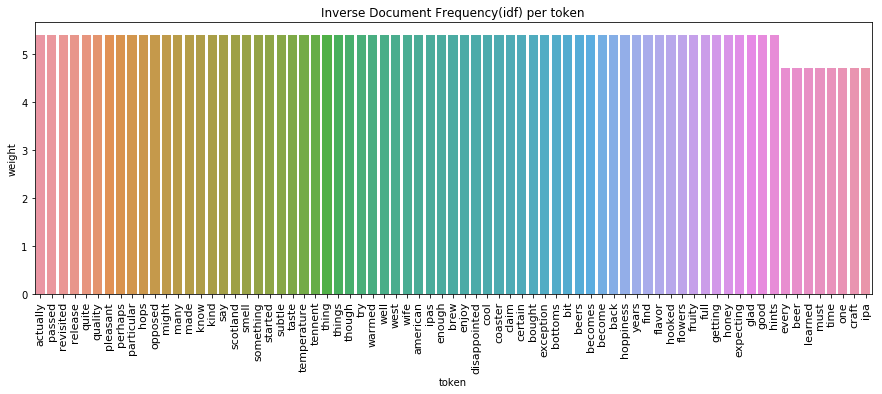

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

txt1 = X[200].split()

tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
txt_fitted = tf.fit(txt1)
txt_transformed = txt_fitted.transform(txt1)
idf = tf.idf_

rr = dict(zip(txt_fitted.get_feature_names(), idf))
token_weight = pd.DataFrame.from_dict(rr, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)
token_weight 

sns.barplot(x='token', y='weight', data=token_weight)            
plt.title("Inverse Document Frequency(idf) per token")
fig=plt.gcf()
fig.set_size_inches(15,5)
_= plt.xticks(rotation='vertical',size=11)
plt.show()

In [42]:
feature_names = np.array(tf.get_feature_names())
sorted_by_idf = np.argsort(tf.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:3]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-3:]]))

Features with lowest idf:
['ipa' 'learned' 'beer']

Features with highest idf:
['expecting' 'getting' 'years']


In [86]:
# NAIVE BAYES PREDICTOR   fast
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve

clf = MultinomialNB(alpha = 0.001)
# first pass, .1195,  after word cleaning .2076,  after combining styles .2639
# ngrams (1,1): .2639  ngrams (1,2): .2117  ngrams (1,3): .20677
# after adding stemmer with ngrams(1,2): .1617
# changed alpha to 0.001, got 0.53!
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print("accuracy score: ", np.mean(predicted == y_test))

print(classification_report(y_test, predicted))

accuracy score:  0.544206558077
                                precision    recall  f1-score   support

                       Altbier       0.58      0.23      0.33        61
      American Amber / Red Ale       0.47      0.34      0.39       420
            American Black Ale       0.75      0.60      0.66       157
           American Blonde Ale       0.58      0.20      0.30       230
American Double / Imperial IPA       0.65      0.48      0.55       793
                American Lager       0.44      0.47      0.46       239
           American Strong Ale       0.49      0.33      0.39       119
             American Wild Ale       0.65      0.71      0.68       558
                    Barleywine       0.52      0.69      0.59       236
              Belgian Dark Ale       0.39      0.16      0.23        68
       Belgian Strong Dark Ale       0.47      0.45      0.46       128
       Belgian Strong Pale Ale       0.54      0.30      0.38       125
            Berliner Weissbier 

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve
precision, recall, thresholds = precision_recall_curve(y_test, predicted)
#fpr, tpr, thresholds = roc_curve(y_test, predicted    )

In [23]:
# GRID search NAIVE BAYES
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.0001,0.001, 0.01]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(X_train, y_train)
print('best cross-val score: {:.2f}'.format(grid.best_score_))
print('best params:', grid.best_params_)

best cross-val score: 0.49
best params: {'alpha': 0.01}


In [87]:
%%time
# RANDOM FOREST 
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators = 1000)
forest_clf.fit(X_train2, y_train2)
forest_predict = forest_clf.predict(X_test2)
print(np.mean(predicted == y_test2))

print(classification_report(y_test, forest_predict))

/Users/brentmarijensen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


0.0


ValueError: Found input variables with inconsistent numbers of samples: [14059, 1000]

In [27]:
%%time
# GRID SEARCH for RANDOM FOREST
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [600, 1000, 2000]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train2, y_train2)
print('best cross-val score: {:.2f}'.format(grid.best_score_))
print('best params:', grid.best_params_)

best cross-val score: 0.41
best params: {'n_estimators': 2000}
CPU times: user 35min 42s, sys: 1min 56s, total: 37min 39s
Wall time: 53min 8s


In [53]:
%%time
# GRADIENT BOOSTING CLASSIFIER  this is slow, with training data 5,000 reviews it takes 54 min
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate= 0.06, n_estimators= 100)
gbc.fit(X_train2, y_train2)
predicted = forest_clf.predict(X_test2) 
print(np.mean(predicted == y_test2))

0.397
CPU times: user 23min 7s, sys: 9.23 s, total: 23min 17s
Wall time: 25min 4s


In [ ]:
# feature importances
feat_imp = pd.Series(gbc.feature_importances_, predicted).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Score')
plt.show()

In [ ]:
%%time
# GRID SEARCH for GBC

param_grid = {'learning_rate': [0.06, 0.1, 1.5], 'n_estimators': [50, 75, 100]}
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)
grid.fit(X_train2, y_train2)
print('best params:', grid.best_params_)

In [16]:
%%time
# LOGISTIC REGRESSION  this takes about 15 minutes on full set
#after cleaning, 0.575,  after combined styles 0.6218
#  increasing ngram lowers to .6060

logreg = LogisticRegression(C=100, tol=0.001)
logreg.fit(X_train, y_train)
predicted = logreg.predict(X_test)
print(np.mean(predicted == y_test))

0.652464613415
CPU times: user 3min 4s, sys: 1.05 s, total: 3min 5s
Wall time: 3min 29s


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

print(classification_report(y_test, predicted))

                                precision    recall  f1-score   support

                       Altbier       0.81      0.56      0.66        61
      American Amber / Red Ale       0.51      0.57      0.54       420
            American Black Ale       0.74      0.64      0.68       157
           American Blonde Ale       0.53      0.50      0.52       230
American Double / Imperial IPA       0.68      0.70      0.69       793
                American Lager       0.58      0.59      0.59       239
           American Strong Ale       0.48      0.38      0.42       119
             American Wild Ale       0.66      0.72      0.69       558
                    Barleywine       0.77      0.75      0.76       236
              Belgian Dark Ale       0.42      0.16      0.23        68
       Belgian Strong Dark Ale       0.57      0.51      0.53       128
       Belgian Strong Pale Ale       0.56      0.37      0.44       125
            Berliner Weissbier       0.77      0.62      0.69  

In [26]:
len(labels)

14059

In [24]:
# use a heat map
import matplotlib.pyplot as plt 
import seaborn as sns
labels = y_test.tolist()
matrix = confusion_matrix(y_test, predicted)

In [27]:
fig= plt.figure( figsize = (10,10))
fig.add_subplot(111)
sns.heatmap(matrix,annot=True,square=True,cbar=False,fmt="d")
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.xticks(labels, rotation = 80)
plt.show()

AttributeError: 'NoneType' object has no attribute 'seq'

In [107]:
print(y_test)

['IPA' 'American Double / Imperial IPA' 'IPA' ..., 'IPA'
 'Kellerbier / Zwickelbier' 'Farm Ale']


In [ ]:
import seaborn as sns

labels = y_test
matrix = confusion_matrix(y_test, predicted, labels)


In [ ]:

fig=plt.figure( figsize = (12,12))
ax = fig.add_subplot(111)
_= sns.heatmap(matrix, annot=True,square=True,cbar=False,fmt="d")
_= plt.xlabel("true label")
_= plt.ylabel("predicted label")
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)

plt.show()

In [49]:
logreg.coef_

array([[ -2.75996866e-02,   0.00000000e+00,  -2.92078367e-03, ...,
         -1.60240681e-03,  -2.47800435e-04,  -2.47800435e-04],
       [ -2.03229571e-01,   0.00000000e+00,  -3.41131009e-02, ...,
         -4.23641057e-03,  -1.09377630e-04,  -1.09377630e-04],
       [ -8.65955765e-02,   0.00000000e+00,  -1.33724374e-02, ...,
         -9.01983017e-04,  -1.34028060e-04,  -1.34028060e-04],
       ..., 
       [ -8.90663943e-02,   0.00000000e+00,  -2.63651722e-02, ...,
         -1.61107214e-03,  -5.88763432e-05,  -5.88763432e-05],
       [ -8.24345869e-02,   0.00000000e+00,  -5.04145964e-02, ...,
         -3.25702057e-03,  -4.09216318e-05,  -4.09216318e-05],
       [ -3.58738295e-02,   0.00000000e+00,  -5.78167415e-03, ...,
         -6.38893506e-04,  -1.46713162e-03,  -1.46713162e-03]])

In [339]:
###  this is quite slow.  
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.01, 0.1, 1,10],'tol':[0.001,0.0001,0.00001]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print('best cross-val score: {:.2f}'.format(grid.best_score_))
print('best params:', grid.best_params_)

best cross-val score: 0.67
best params: {'C': 10, 'tol': 0.001}


In [95]:
# KMEANS COULD BE USED TO GROUP STYLES TOGETHER.  (use this before consolidating)
from sklearn.cluster import KMeans

# DATA PREP
group_df = df_copy
# drop all reviews with < 20 characters
group_df = group_df[group_df['review'].map(len) > 20]

# Change review to a string of words.  remove non-letters, make lower case, split into words.  
# Remove stopwords (common words.)  Join back together into a long string of words.  
def review_to_words(review):
    letters_only = re.sub('[^a-zA-Z]',' ', review)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))  
    good_words = [w for w in words if not w in stops]
    return(' '.join(good_words))

# clean the reviews
df['clean_group_df'] = df['review'].apply(review_to_words)

vectorizer = CountVectorizer(analyzer='word', min_df=7)
train_data_features = vectorizer.fit_transform(df.clean_group_df)

# Initialize the model with 2 parameters -- number of clusters and random state.
kmeans_model = KMeans(n_clusters=20, random_state=22)
# Get only the styles
styles = group_df.style
variables = train_data_features
# Fit the model using the good columns.
kmeans_model.fit(variables)
# Get the cluster assignments.
labels = kmeans_model.labels_

In [ ]:
# Import the PCA model.
from sklearn.decomposition import PCA

# Create a PCA model.
pca_2 = PCA(2)
# Fit the PCA model on the numeric columns from earlier.
plot_columns = pca_2.fit_transform(labels)
# Make a scatter plot of each game, shaded according to cluster assignment.
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
# Show the plot.
plt.show()

In [ ]:
# or maybe try k nearest neighbors

from aklean.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit()
prediction = knn.predict

### PREDICT RATING FROM REVIEW
random will have std deviation about .70

In [15]:
print('ready')

ready


In [33]:
# PREDICT RATING FROM REVIEWS
from sklearn.preprocessing import Normalizer

X = df['clean_review'].values
y = df['style'].values

# vectorize the train data, fit and transform into feature vectors
vectorizer = CountVectorizer(analyzer='word', min_df=2, ngram_range = (1,2))
X_counts = vectorizer.fit_transform(X)
#scaler = Normalizer()
#X_scaled = scaler.fit_transform(X_counts)
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_scaled)


# split into train and test data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y, test_size=0.3, random_state=22)
# make a small set for param tuning
"""X_train2 = X_train[:3600]
y_train2 = y_train[:3600]
X_test2 = X_test[1000:2000]
y_test2 = y_test[1000:2000]"""

print('X_train shape:',X_train.shape)
print('X_test shape:',y_train.shape)

X_train shape: (32802, 815874)
X_test shape: (32802,)


In [34]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [35]:
linreg.fit(X_train, y_train)

ValueError: could not convert string to float: 'Berliner Weissbier'

In [22]:
%%time
# LINEAR REGRESSION model to predict a rating based on a review
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
predicted = linreg.predict(X_test)
difference = ( y_test - predicted )
print(np.mean(difference))
print(np.std(difference))

ValueError: could not convert string to float: 'Berliner Weissbier'

In [26]:
%%time
# RIDGE regression
from sklearn.linear_model import Ridge

ridge = Ridge(alpha= 0.1, tol= 0.01, normalize = True)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
print('ridge score:',ridge.score(X_test, y_test))
ridge_difference = y_test-ridge_pred
print('mean:',np.mean(ridge_difference))
print('std:', np.std(ridge_difference))

ValueError: could not convert string to float: 'Berliner Weissbier'

In [444]:
%%time
###  GRID search RIDGE
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 1, 10],'tol':[1, 0.1,0.01]}
grid = GridSearchCV(Ridge(), param_grid, cv=5)
grid.fit(X_train, y_train)
print('best cross-val score: {:.2f}'.format(grid.best_score_))
print('best params:', grid.best_params_)

best cross-val score: 0.49
best params: {'alpha': 0.1, 'tol': 0.01}
CPU times: user 43.2 s, sys: 1.49 s, total: 44.7 s
Wall time: 45.4 s


In [449]:
%%time
# LASSO  
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.0001, tol=1)
lasso.fit(X_train, y_train)
predicted = lasso.predict(X_test)
difference = y_test-predicted  
print(np.mean(difference))
print(np.std(difference))

-0.000133983689325
0.328980031385
CPU times: user 5.69 s, sys: 47.8 ms, total: 5.74 s
Wall time: 5.95 s


In [450]:
%%time
# GRID search LASSO
param_grid = {'alpha': [0.00001, 0.0001, 0.001],'tol':[0.1, 1, 10]}
grid = GridSearchCV(Lasso(), param_grid, cv=5)
grid.fit(X_train, y_train)
print('best params:', grid.best_params_)

best params: {'alpha': 0.0001, 'tol': 1}
CPU times: user 5min 1s, sys: 1.59 s, total: 5min 3s
Wall time: 5min 5s


In [463]:
# RANDOM predict random results for a benchmark
y_mean = np.mean(y_test)
y_std = np.std(y_test)
samples= np.random.normal(y_mean,y_std,len(y_test))
diff = y_test-samples
print('random sample mean:',np.mean(diff))
print('random sample std dev:',np.std(diff))

random sample mean: 0.00238704963056
random sample std dev: 0.625903532274


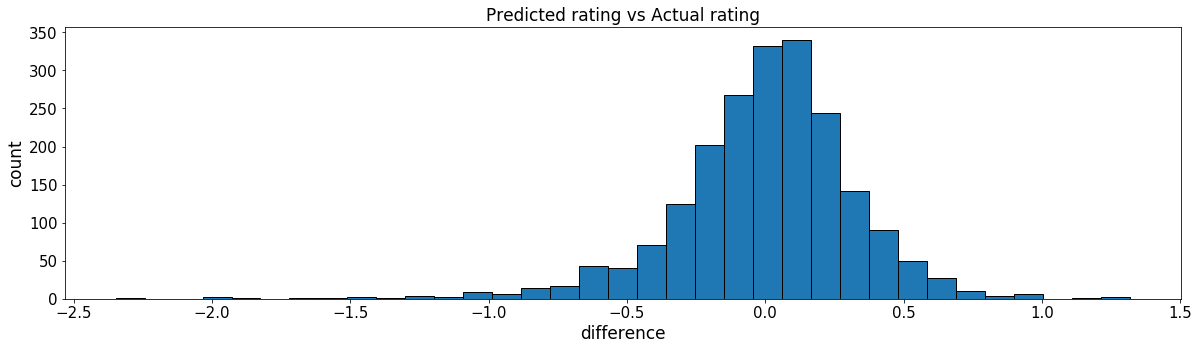

mean: -0.000133983689325
std: 0.328980031385


In [451]:
# difference of model from user rating
import matplotlib.pyplot as plt
_= plt.figure(figsize=(20,5))
_= plt.hist(difference, bins=35, edgecolor="k")
_= plt.xticks(size=15)
_= plt.yticks(size=15)
_= plt.xlabel('difference', size=17)
_= plt.ylabel('count', size=17)
_= plt.title('Predicted rating vs Actual rating', size=17)
plt.show()
mean_diff = np.mean(difference)
std_diff = np.std(difference)
print('mean:',mean_diff)
print('std:',std_diff)

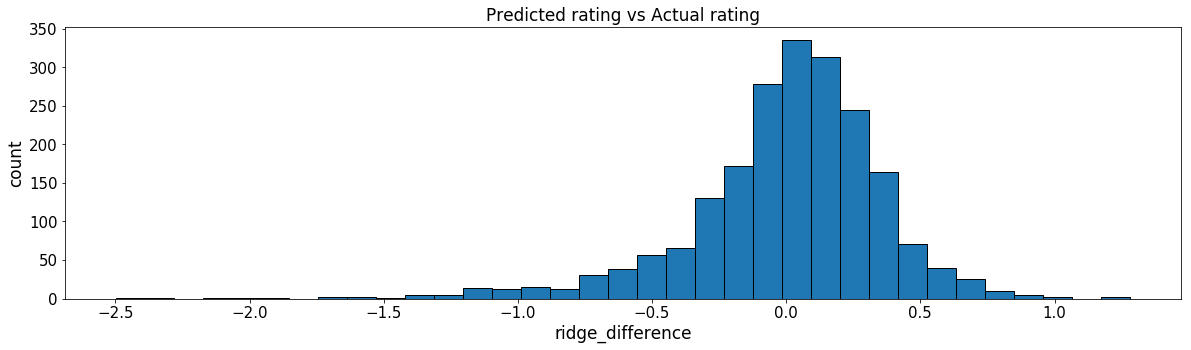

mean: 0.0012147733151
std: 0.367829445211


In [407]:
# difference of model from user rating for RIDGE
import matplotlib.pyplot as plt
_= plt.figure(figsize=(20,5))
_= plt.hist(ridge_difference, bins=35, edgecolor="k")
_= plt.xticks(size=15)
_= plt.yticks(size=15)
_= plt.xlabel('ridge_difference', size=17)
_= plt.ylabel('count', size=17)
_= plt.title('Predicted rating vs Actual rating', size=17)
plt.show()
mean_diff = np.mean(ridge_difference)
std_diff = np.std(ridge_difference)
print('mean:',mean_diff)
print('std:',std_diff)

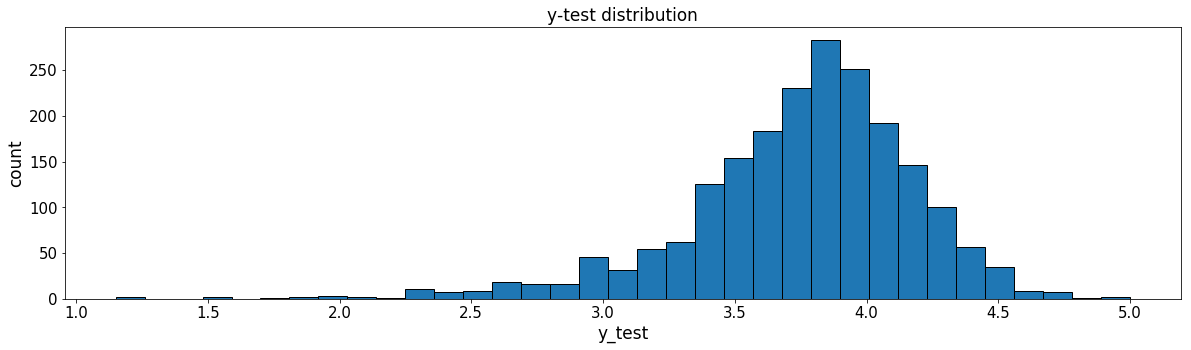

In [455]:
# difference of model from user rating
import matplotlib.pyplot as plt
_= plt.figure(figsize=(20,5))
_= plt.hist(y_test, bins=35, edgecolor="k")
_= plt.xticks(size=15)
_= plt.yticks(size=15)
_= plt.xlabel('y_test', size=17)
_= plt.ylabel('count', size=17)
_= plt.title('y-test distribution', size=17)
plt.show()

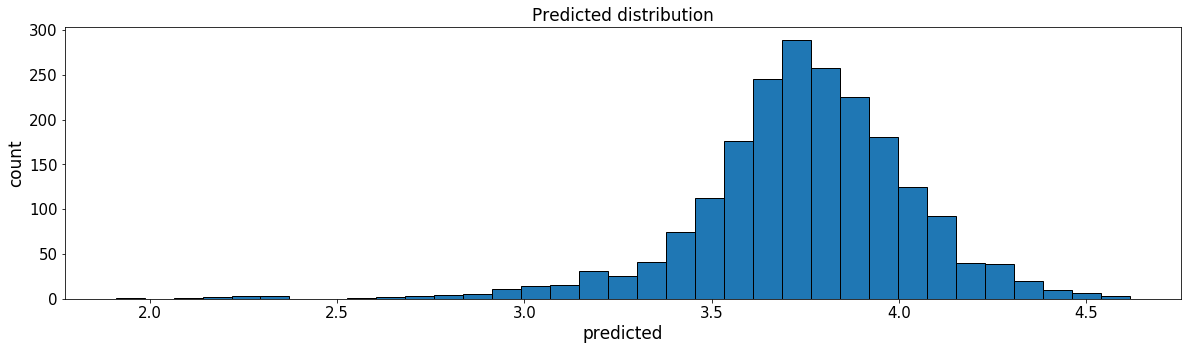

In [454]:
import matplotlib.pyplot as plt
_= plt.figure(figsize=(20,5))
_= plt.hist(predicted, bins=35, edgecolor="k")
_= plt.xticks(size=15)
_= plt.yticks(size=15)
_= plt.xlabel('predicted', size=17)
_= plt.ylabel('count', size=17)
_= plt.title('Predicted distribution', size=17)
plt.show()

0.0120194667192
0.627979976671
